<a href="https://colab.research.google.com/github/hoangtu1234/GenAI-LatentModel/blob/main/GenAI_LatentModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
!unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul
from deepul.hw2_helper import *


Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 33.94 MiB/s, done.
Resolving deltas: 100% (95/95), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0  50.5M      0  0:00:04  0:00:04 --:--:-- 51.5M
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22738 sha256=f77d0b58e1e4501f58a8d1f10e1af8bd24a24ad7ddd3d0b819d019e50609abfc
  Stored in directory: /tmp/pip-ephem-wheel-cache-zo58o2xp/wheels/89/4d/b7/d666c1fdc2a51554c762f2cfe90dad1098871e7fea5c53eed4
Successfully built deepul


# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


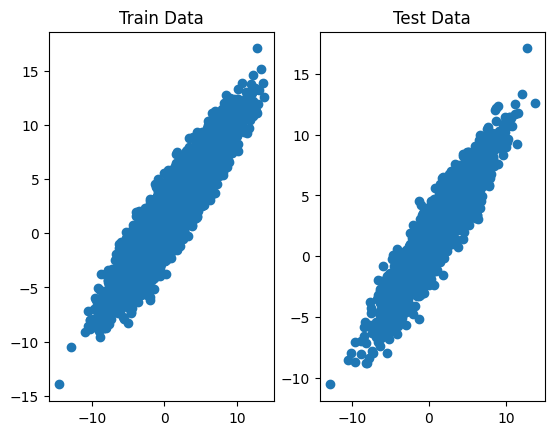

Dataset 2


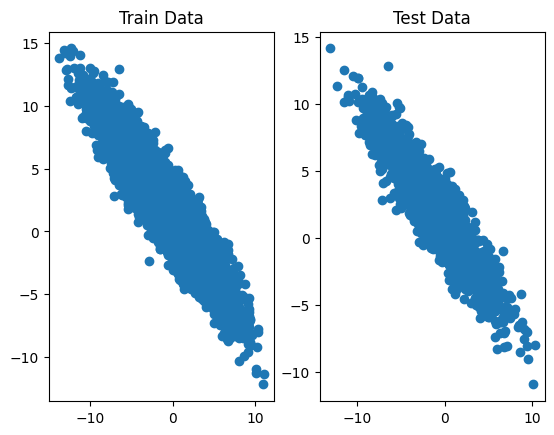

In [ ]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
def train(model, data_loader, optimizer, epoch, grad_clip = None):
  batch_iter = tqdm(data_loader)
  model.train()
  loss_dict = OrderedDict()
  for x in batch_iter:
    x = x.cuda()
    out_put = model.loss(x)
    optimizer.zero_grad()
    out_put['loss'].backward()
    if grad_clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()

    desc = f'Epoch: {epoch}'

    for key, value in out_put.items():
      if key not in loss_dict:
        loss_dict[key] = []
      loss_dict[key].append(value.item())
      avg_loss = np.mean(loss_dict[key])
      desc += f'{key}: {avg_loss:.4f}'
    batch_iter.set_description(desc)
  batch_iter.close()
  return loss_dict
def eval(model, data_loader):
  model.eval()
  loss_dict = OrderedDict()
  with torch.no_grad():
    for x in data_loader:
      x = x.cuda()
      out_put = model.loss(x)
      for key, value in out_put.items():
          loss_dict[key] = loss_dict.get(key,0) + value.item() * x.size(0)
    desc = f'test: '
    for key in loss_dict.keys():
      loss_dict[key] /= len(data_loader.dataset)
      desc += f'{key}: {loss_dict[key]:.4f} '
    print(desc)
  return loss_dict


def train_epoch(model, train_loader, test_loader, train_args):
  optimizer = train_args['optimizer']
  epochs = train_args['epochs']
  grad_clip = train_args.get('grad_clip', None)

  device = 'cuda' if torch.cuda.is_available() else "cpu"
  model.to(device)

  train_loss = OrderedDict()
  test_loss = OrderedDict()
  eval_output = eval(model, test_loader)
  for key, value in eval_output.items():
    if key not in test_loss:
      test_loss[key] = []
    test_loss[key].append(value)
  for epoch in range(epochs):
    model.train()
    train_output = train(model, train_loader, optimizer, epoch, grad_clip)
    eval_output = eval(model, test_loader)

    for key in train_output.keys():
      if key not in train_loss:
        train_loss[key] = []
      train_loss[key].extend(train_output[key])
      test_loss[key].append(eval_output[key])
  return train_loss, test_loss


In [ ]:
class DistributionParameterization(nn.Module):
  def __init__(self,input_dim , output_dim , hidden_size ):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hidden_size = hidden_size
    input_number = np.prod(input_dim)
    output_number = np.prod(output_dim)

    self.layers = []
    layers_size = [input_number] + hidden_size + [output_number]
    for in_dim, out_dim in zip(layers_size[:-1], layers_size[1:]):
      self.layers.extend([
          nn.Linear(in_dim, out_dim),
          nn.ReLU(),
      ])
    self.layers.pop()
    self.net = nn.Sequential(*self.layers)
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.contiguous().view(batch_size, -1)
    return self.net(x).contiguous().view(batch_size, *self.output_dim)
class FullyConnectedVAE(nn.Module):
  def __init__(self, input_dim, latent_dim, encoder_hidden, decoder_hidden):
    super().__init__()
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.q_dis = DistributionParameterization((input_dim,),(2*latent_dim,), encoder_hidden)
    self.p_dis = DistributionParameterization((latent_dim,),(2*input_dim,), decoder_hidden)
  def loss(self, x):
    mu_q, log_var_q = self.q_dis(x).chunk(2, dim = 1)
    z = torch.randn_like(mu_q)*torch.sqrt(log_var_q.exp()) + mu_q
    mu_p, log_var_p = self.p_dis(z).chunk(2, dim =1)




    recon_loss = 0.5*np.log(2*np.pi) + torch.log(torch.sqrt(log_var_p.exp())) + ((x - mu_p)**2*torch.exp(-1 * log_var_p))*0.5
    avg_reconstruction_loss = recon_loss.sum(dim = 1).mean()

    kl_loss = 0.5*(mu_q**2 + torch.exp(log_var_q)) - self.latent_dim/(2* self.latent_dim) - 0.5*log_var_q

    avg_kl_loss = kl_loss.sum(dim = 1).mean()
    return OrderedDict(loss = avg_reconstruction_loss + avg_kl_loss, recon_loss = avg_reconstruction_loss, kl_loss = avg_kl_loss)
  def sample(self, n, noise = True):
    with torch.no_grad():
      z = torch.randn(n, self.latent_dim).cuda()
      mu_z, log_var_z = self.p_dis(z).chunk(2, dim = 1)
      if noise:
        z = torch.randn_like(mu_z)*log_var_z.exp() + mu_z
      else:
        z = mu_z
    return z.cpu().numpy()






In [ ]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """


    model = FullyConnectedVAE(2, 2, [128, 128], [128, 128])
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epoch(model, train_loader, test_loader,
                                             dict(epochs=20, optimizer = optimizer, grad_clip = 1))
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

test: loss: 16.8314 recon_loss: 16.6049 kl_loss: 0.2266 


Epoch: 0loss: 6.4406recon_loss: 6.0530kl_loss: 0.3875: 100%|██████████| 79/79 [00:01<00:00, 76.35it/s]


test: loss: 5.3578 recon_loss: 5.1412 kl_loss: 0.2166 


Epoch: 1loss: 5.3441recon_loss: 5.1257kl_loss: 0.2184: 100%|██████████| 79/79 [00:01<00:00, 65.60it/s]


test: loss: 5.3222 recon_loss: 5.0986 kl_loss: 0.2236 


Epoch: 2loss: 5.2954recon_loss: 4.9782kl_loss: 0.3172: 100%|██████████| 79/79 [00:01<00:00, 77.86it/s]


test: loss: 5.0440 recon_loss: 4.4056 kl_loss: 0.6384 


Epoch: 3loss: 4.8783recon_loss: 3.7360kl_loss: 1.1423: 100%|██████████| 79/79 [00:01<00:00, 77.26it/s]


test: loss: 4.6867 recon_loss: 3.3977 kl_loss: 1.2891 


Epoch: 4loss: 4.6645recon_loss: 3.2258kl_loss: 1.4387: 100%|██████████| 79/79 [00:01<00:00, 61.29it/s]


test: loss: 4.5462 recon_loss: 3.0466 kl_loss: 1.4996 


Epoch: 5loss: 4.5598recon_loss: 3.0459kl_loss: 1.5138: 100%|██████████| 79/79 [00:01<00:00, 73.42it/s]


test: loss: 4.6015 recon_loss: 3.1536 kl_loss: 1.4479 


Epoch: 6loss: 4.5050recon_loss: 2.9554kl_loss: 1.5496: 100%|██████████| 79/79 [00:00<00:00, 79.01it/s]


test: loss: 4.4912 recon_loss: 2.9496 kl_loss: 1.5416 


Epoch: 7loss: 4.4821recon_loss: 2.9161kl_loss: 1.5660: 100%|██████████| 79/79 [00:01<00:00, 55.50it/s]


test: loss: 4.4402 recon_loss: 2.8940 kl_loss: 1.5462 


Epoch: 8loss: 4.4807recon_loss: 2.8825kl_loss: 1.5982: 100%|██████████| 79/79 [00:01<00:00, 62.67it/s]


test: loss: 4.4227 recon_loss: 2.8607 kl_loss: 1.5619 


Epoch: 9loss: 4.4895recon_loss: 2.9289kl_loss: 1.5606: 100%|██████████| 79/79 [00:01<00:00, 57.24it/s]


test: loss: 4.5272 recon_loss: 2.8751 kl_loss: 1.6521 


Epoch: 10loss: 4.4784recon_loss: 2.9050kl_loss: 1.5735: 100%|██████████| 79/79 [00:01<00:00, 76.31it/s]


test: loss: 4.5022 recon_loss: 2.9214 kl_loss: 1.5808 


Epoch: 11loss: 4.4805recon_loss: 2.8943kl_loss: 1.5861: 100%|██████████| 79/79 [00:01<00:00, 74.55it/s]


test: loss: 4.4429 recon_loss: 2.8953 kl_loss: 1.5476 


Epoch: 12loss: 4.4613recon_loss: 2.8705kl_loss: 1.5908: 100%|██████████| 79/79 [00:01<00:00, 57.09it/s]


test: loss: 4.4818 recon_loss: 2.9918 kl_loss: 1.4901 


Epoch: 13loss: 4.4512recon_loss: 2.8681kl_loss: 1.5831: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


test: loss: 4.4301 recon_loss: 2.8758 kl_loss: 1.5543 


Epoch: 14loss: 4.4687recon_loss: 2.8652kl_loss: 1.6035: 100%|██████████| 79/79 [00:00<00:00, 84.65it/s]


test: loss: 4.4715 recon_loss: 2.8937 kl_loss: 1.5779 


Epoch: 15loss: 4.4810recon_loss: 2.8733kl_loss: 1.6077: 100%|██████████| 79/79 [00:00<00:00, 137.88it/s]


test: loss: 4.4931 recon_loss: 2.9016 kl_loss: 1.5914 


Epoch: 16loss: 4.4681recon_loss: 2.8861kl_loss: 1.5820: 100%|██████████| 79/79 [00:00<00:00, 125.08it/s]


test: loss: 4.4675 recon_loss: 2.9496 kl_loss: 1.5179 


Epoch: 17loss: 4.4593recon_loss: 2.8717kl_loss: 1.5876: 100%|██████████| 79/79 [00:00<00:00, 142.61it/s]


test: loss: 4.4654 recon_loss: 2.9028 kl_loss: 1.5626 


Epoch: 18loss: 4.4755recon_loss: 2.8696kl_loss: 1.6059: 100%|██████████| 79/79 [00:00<00:00, 147.70it/s]


test: loss: 4.4582 recon_loss: 2.7718 kl_loss: 1.6864 


Epoch: 19loss: 4.4748recon_loss: 2.8740kl_loss: 1.6008: 100%|██████████| 79/79 [00:00<00:00, 127.88it/s]


test: loss: 4.4539 recon_loss: 2.8801 kl_loss: 1.5738 
Final -ELBO: 4.4539, Recon Loss: 2.8801, KL Loss: 1.5738


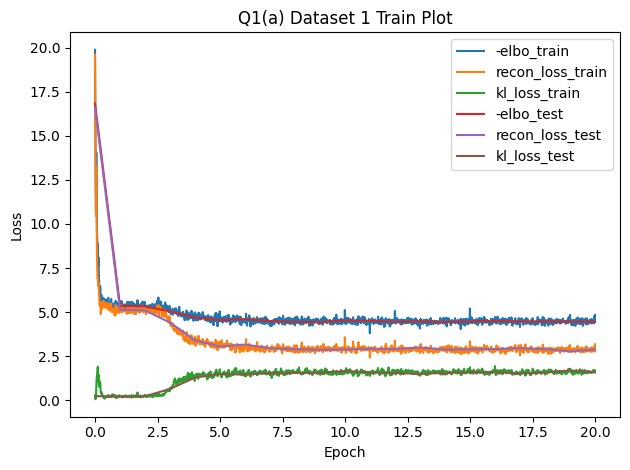

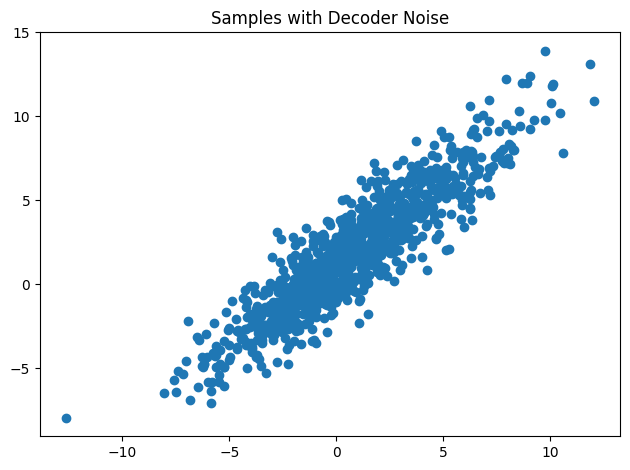

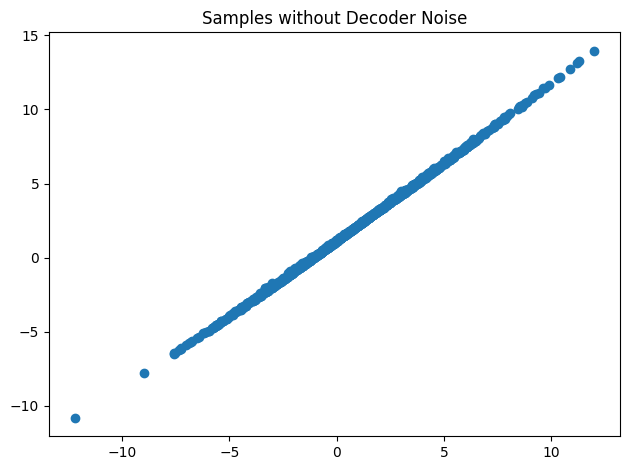

In [ ]:
q1_save_results('a', 1, q1)

test: loss: 16.7312 recon_loss: 16.6149 kl_loss: 0.1163 


Epoch: 0loss: 6.3156recon_loss: 6.0207kl_loss: 0.2949: 100%|██████████| 79/79 [00:00<00:00, 110.55it/s]


test: loss: 5.3443 recon_loss: 5.2390 kl_loss: 0.1053 


Epoch: 1loss: 5.1902recon_loss: 4.7380kl_loss: 0.4521: 100%|██████████| 79/79 [00:00<00:00, 106.88it/s]


test: loss: 4.9426 recon_loss: 4.0488 kl_loss: 0.8938 


Epoch: 2loss: 4.8258recon_loss: 3.6442kl_loss: 1.1817: 100%|██████████| 79/79 [00:00<00:00, 150.17it/s]


test: loss: 4.6694 recon_loss: 3.4240 kl_loss: 1.2454 


Epoch: 3loss: 4.6773recon_loss: 3.3114kl_loss: 1.3659: 100%|██████████| 79/79 [00:00<00:00, 134.01it/s]


test: loss: 4.5783 recon_loss: 3.1756 kl_loss: 1.4027 


Epoch: 4loss: 4.5294recon_loss: 3.0369kl_loss: 1.4924: 100%|██████████| 79/79 [00:00<00:00, 129.10it/s]


test: loss: 4.4945 recon_loss: 3.0481 kl_loss: 1.4463 


Epoch: 5loss: 4.4737recon_loss: 2.9310kl_loss: 1.5427: 100%|██████████| 79/79 [00:00<00:00, 128.63it/s]


test: loss: 4.4795 recon_loss: 2.8416 kl_loss: 1.6380 


Epoch: 6loss: 4.4919recon_loss: 2.9177kl_loss: 1.5741: 100%|██████████| 79/79 [00:00<00:00, 138.93it/s]


test: loss: 4.4698 recon_loss: 2.7995 kl_loss: 1.6703 


Epoch: 7loss: 4.4762recon_loss: 2.9291kl_loss: 1.5471: 100%|██████████| 79/79 [00:00<00:00, 151.15it/s]


test: loss: 4.4760 recon_loss: 2.9264 kl_loss: 1.5496 


Epoch: 8loss: 4.4682recon_loss: 2.8917kl_loss: 1.5765: 100%|██████████| 79/79 [00:00<00:00, 131.09it/s]


test: loss: 4.5280 recon_loss: 2.9672 kl_loss: 1.5608 


Epoch: 9loss: 4.4761recon_loss: 2.8967kl_loss: 1.5795: 100%|██████████| 79/79 [00:00<00:00, 127.34it/s]


test: loss: 4.4363 recon_loss: 2.8864 kl_loss: 1.5499 


Epoch: 10loss: 4.4611recon_loss: 2.8754kl_loss: 1.5857: 100%|██████████| 79/79 [00:00<00:00, 128.70it/s]


test: loss: 4.4674 recon_loss: 2.7742 kl_loss: 1.6932 


Epoch: 11loss: 4.4654recon_loss: 2.8969kl_loss: 1.5685: 100%|██████████| 79/79 [00:00<00:00, 124.00it/s]


test: loss: 4.4552 recon_loss: 2.9108 kl_loss: 1.5444 


Epoch: 12loss: 4.4789recon_loss: 2.9005kl_loss: 1.5784: 100%|██████████| 79/79 [00:00<00:00, 151.63it/s]


test: loss: 4.5259 recon_loss: 2.9746 kl_loss: 1.5512 


Epoch: 13loss: 4.4706recon_loss: 2.9122kl_loss: 1.5584: 100%|██████████| 79/79 [00:00<00:00, 145.47it/s]


test: loss: 4.4714 recon_loss: 2.9905 kl_loss: 1.4809 


Epoch: 14loss: 4.4693recon_loss: 2.9111kl_loss: 1.5582: 100%|██████████| 79/79 [00:00<00:00, 125.23it/s]


test: loss: 4.4765 recon_loss: 2.9241 kl_loss: 1.5524 


Epoch: 15loss: 4.4601recon_loss: 2.8777kl_loss: 1.5824: 100%|██████████| 79/79 [00:00<00:00, 127.32it/s]


test: loss: 4.4577 recon_loss: 2.9755 kl_loss: 1.4821 


Epoch: 16loss: 4.4527recon_loss: 2.8651kl_loss: 1.5875: 100%|██████████| 79/79 [00:00<00:00, 126.31it/s]


test: loss: 4.4532 recon_loss: 2.8478 kl_loss: 1.6054 


Epoch: 17loss: 4.4646recon_loss: 2.8864kl_loss: 1.5782: 100%|██████████| 79/79 [00:00<00:00, 111.47it/s]


test: loss: 4.4914 recon_loss: 2.9094 kl_loss: 1.5820 


Epoch: 18loss: 4.4709recon_loss: 2.9064kl_loss: 1.5645: 100%|██████████| 79/79 [00:00<00:00, 119.46it/s]


test: loss: 4.4205 recon_loss: 2.8130 kl_loss: 1.6075 


Epoch: 19loss: 4.4609recon_loss: 2.8618kl_loss: 1.5990: 100%|██████████| 79/79 [00:00<00:00, 107.30it/s]


test: loss: 4.4860 recon_loss: 2.8228 kl_loss: 1.6632 
Final -ELBO: 4.4860, Recon Loss: 2.8228, KL Loss: 1.6632


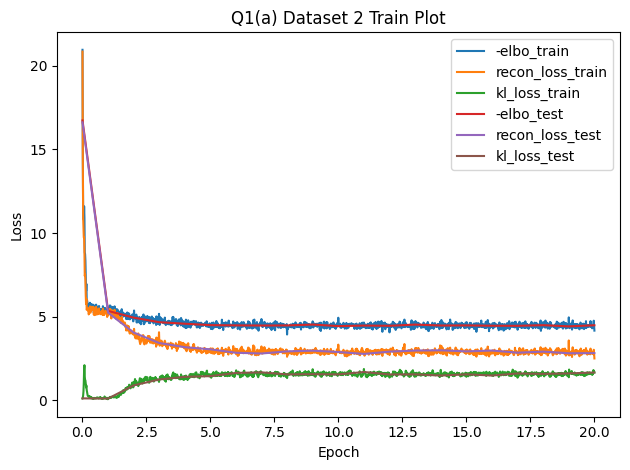

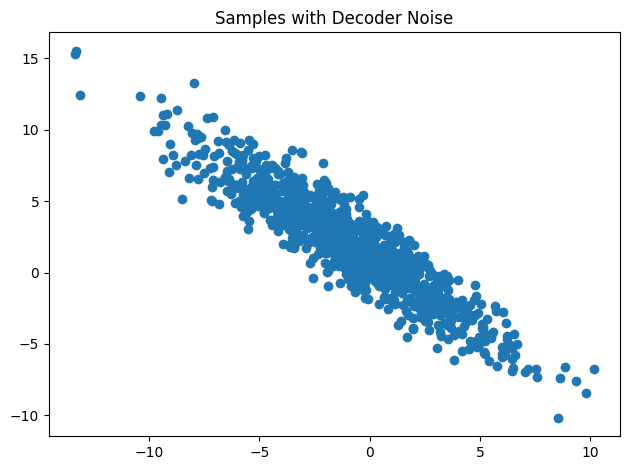

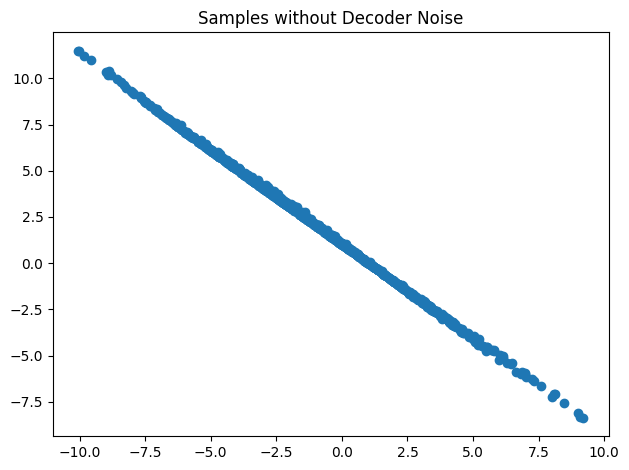

In [ ]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


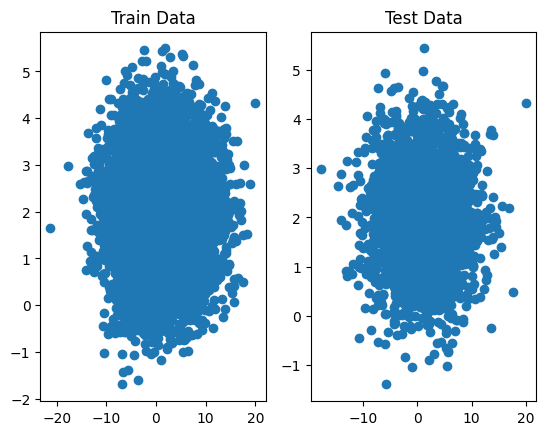

Dataset 2


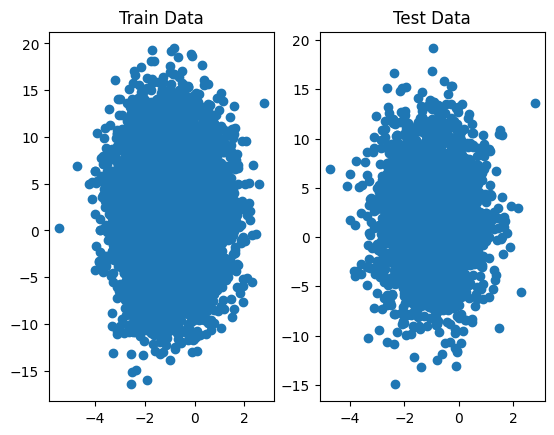

In [ ]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

test: loss: 14.9422 recon_loss: 14.6732 kl_loss: 0.2691 


Epoch: 0loss: 5.4183recon_loss: 5.1096kl_loss: 0.3087: 100%|██████████| 79/79 [00:00<00:00, 136.65it/s]


test: loss: 4.4437 recon_loss: 4.4120 kl_loss: 0.0317 


Epoch: 1loss: 4.4456recon_loss: 4.4225kl_loss: 0.0231: 100%|██████████| 79/79 [00:00<00:00, 144.30it/s]


test: loss: 4.4290 recon_loss: 4.4135 kl_loss: 0.0154 


Epoch: 2loss: 4.4396recon_loss: 4.4273kl_loss: 0.0123: 100%|██████████| 79/79 [00:00<00:00, 125.01it/s]


test: loss: 4.4241 recon_loss: 4.4092 kl_loss: 0.0149 


Epoch: 3loss: 4.4391recon_loss: 4.4287kl_loss: 0.0104: 100%|██████████| 79/79 [00:00<00:00, 130.69it/s]


test: loss: 4.4304 recon_loss: 4.4203 kl_loss: 0.0101 


Epoch: 4loss: 4.4361recon_loss: 4.4263kl_loss: 0.0098: 100%|██████████| 79/79 [00:00<00:00, 152.07it/s]


test: loss: 4.4256 recon_loss: 4.4145 kl_loss: 0.0112 


Epoch: 5loss: 4.4335recon_loss: 4.4233kl_loss: 0.0102: 100%|██████████| 79/79 [00:00<00:00, 117.69it/s]


test: loss: 4.4180 recon_loss: 4.4062 kl_loss: 0.0117 


Epoch: 6loss: 4.4371recon_loss: 4.4257kl_loss: 0.0113: 100%|██████████| 79/79 [00:00<00:00, 117.80it/s]


test: loss: 4.4236 recon_loss: 4.4083 kl_loss: 0.0153 


Epoch: 7loss: 4.4462recon_loss: 4.4246kl_loss: 0.0217: 100%|██████████| 79/79 [00:00<00:00, 145.20it/s]


test: loss: 4.4450 recon_loss: 4.4166 kl_loss: 0.0283 


Epoch: 8loss: 4.4406recon_loss: 4.4196kl_loss: 0.0211: 100%|██████████| 79/79 [00:00<00:00, 125.29it/s]


test: loss: 4.4255 recon_loss: 4.4055 kl_loss: 0.0200 


Epoch: 9loss: 4.4318recon_loss: 4.4147kl_loss: 0.0172: 100%|██████████| 79/79 [00:00<00:00, 124.73it/s]


test: loss: 4.4323 recon_loss: 4.4181 kl_loss: 0.0142 


Epoch: 10loss: 4.4415recon_loss: 4.4299kl_loss: 0.0116: 100%|██████████| 79/79 [00:00<00:00, 137.32it/s]


test: loss: 4.4281 recon_loss: 4.4191 kl_loss: 0.0090 


Epoch: 11loss: 4.4407recon_loss: 4.4292kl_loss: 0.0115: 100%|██████████| 79/79 [00:00<00:00, 128.50it/s]


test: loss: 4.4201 recon_loss: 4.4079 kl_loss: 0.0122 


Epoch: 12loss: 4.4369recon_loss: 4.4252kl_loss: 0.0117: 100%|██████████| 79/79 [00:00<00:00, 133.07it/s]


test: loss: 4.4269 recon_loss: 4.4160 kl_loss: 0.0110 


Epoch: 13loss: 4.4376recon_loss: 4.4272kl_loss: 0.0104: 100%|██████████| 79/79 [00:00<00:00, 123.86it/s]


test: loss: 4.4305 recon_loss: 4.4214 kl_loss: 0.0091 


Epoch: 14loss: 4.4353recon_loss: 4.4242kl_loss: 0.0111: 100%|██████████| 79/79 [00:00<00:00, 107.77it/s]


test: loss: 4.4335 recon_loss: 4.4162 kl_loss: 0.0173 


Epoch: 15loss: 4.4368recon_loss: 4.4222kl_loss: 0.0147: 100%|██████████| 79/79 [00:00<00:00, 112.46it/s]


test: loss: 4.4247 recon_loss: 4.4101 kl_loss: 0.0146 


Epoch: 16loss: 4.4376recon_loss: 4.4259kl_loss: 0.0117: 100%|██████████| 79/79 [00:00<00:00, 102.59it/s]


test: loss: 4.4222 recon_loss: 4.4135 kl_loss: 0.0087 


Epoch: 17loss: 4.4413recon_loss: 4.4335kl_loss: 0.0078: 100%|██████████| 79/79 [00:00<00:00, 125.39it/s]


test: loss: 4.4257 recon_loss: 4.4205 kl_loss: 0.0053 


Epoch: 18loss: 4.4335recon_loss: 4.4280kl_loss: 0.0055: 100%|██████████| 79/79 [00:00<00:00, 132.94it/s]


test: loss: 4.4206 recon_loss: 4.4154 kl_loss: 0.0052 


Epoch: 19loss: 4.4382recon_loss: 4.4332kl_loss: 0.0051: 100%|██████████| 79/79 [00:00<00:00, 145.82it/s]


test: loss: 4.4284 recon_loss: 4.4221 kl_loss: 0.0063 
Final -ELBO: 4.4284, Recon Loss: 4.4221, KL Loss: 0.0063


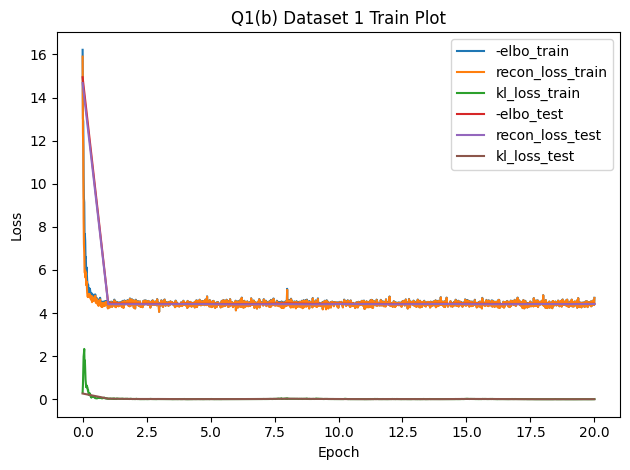

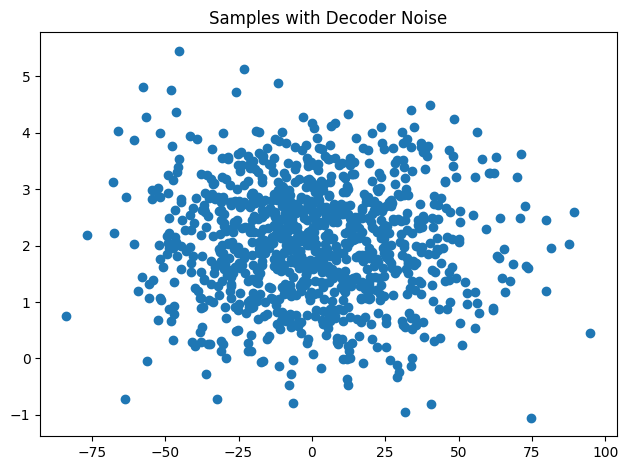

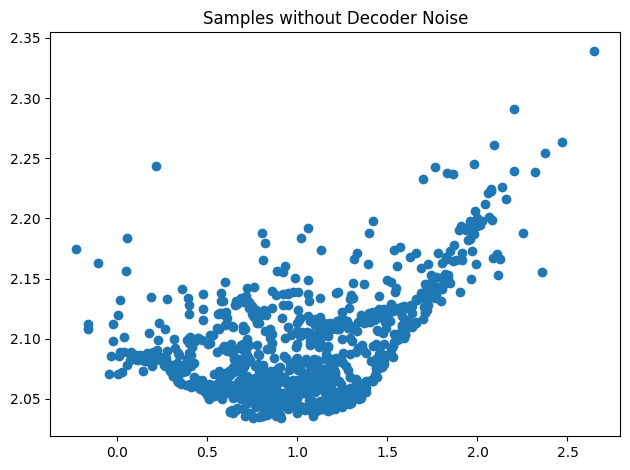

In [ ]:
q1_save_results('b', 1, q1)

test: loss: 16.6724 recon_loss: 16.4797 kl_loss: 0.1927 


Epoch: 0loss: 5.5658recon_loss: 5.2023kl_loss: 0.3635: 100%|██████████| 79/79 [00:00<00:00, 148.75it/s]


test: loss: 4.4481 recon_loss: 4.4108 kl_loss: 0.0373 


Epoch: 1loss: 4.4452recon_loss: 4.4271kl_loss: 0.0181: 100%|██████████| 79/79 [00:00<00:00, 129.46it/s]


test: loss: 4.4282 recon_loss: 4.4114 kl_loss: 0.0168 


Epoch: 2loss: 4.4443recon_loss: 4.4298kl_loss: 0.0145: 100%|██████████| 79/79 [00:00<00:00, 123.52it/s]


test: loss: 4.4279 recon_loss: 4.4179 kl_loss: 0.0100 


Epoch: 3loss: 4.4436recon_loss: 4.4343kl_loss: 0.0093: 100%|██████████| 79/79 [00:00<00:00, 140.71it/s]


test: loss: 4.4227 recon_loss: 4.4167 kl_loss: 0.0060 


Epoch: 4loss: 4.4448recon_loss: 4.4397kl_loss: 0.0051: 100%|██████████| 79/79 [00:00<00:00, 135.47it/s]


test: loss: 4.4324 recon_loss: 4.4253 kl_loss: 0.0072 


Epoch: 5loss: 4.4408recon_loss: 4.4356kl_loss: 0.0052: 100%|██████████| 79/79 [00:00<00:00, 121.35it/s]


test: loss: 4.4214 recon_loss: 4.4162 kl_loss: 0.0052 


Epoch: 6loss: 4.4442recon_loss: 4.4400kl_loss: 0.0042: 100%|██████████| 79/79 [00:00<00:00, 140.25it/s]


test: loss: 4.4343 recon_loss: 4.4294 kl_loss: 0.0049 


Epoch: 7loss: 4.4382recon_loss: 4.4324kl_loss: 0.0057: 100%|██████████| 79/79 [00:00<00:00, 135.99it/s]


test: loss: 4.4273 recon_loss: 4.4197 kl_loss: 0.0075 


Epoch: 8loss: 4.4386recon_loss: 4.4315kl_loss: 0.0071: 100%|██████████| 79/79 [00:00<00:00, 123.91it/s]


test: loss: 4.4276 recon_loss: 4.4190 kl_loss: 0.0086 


Epoch: 9loss: 4.4357recon_loss: 4.4248kl_loss: 0.0110: 100%|██████████| 79/79 [00:00<00:00, 146.62it/s]


test: loss: 4.4294 recon_loss: 4.4206 kl_loss: 0.0088 


Epoch: 10loss: 4.4333recon_loss: 4.4245kl_loss: 0.0088: 100%|██████████| 79/79 [00:00<00:00, 139.47it/s]


test: loss: 4.4266 recon_loss: 4.4187 kl_loss: 0.0079 


Epoch: 11loss: 4.4402recon_loss: 4.4339kl_loss: 0.0063: 100%|██████████| 79/79 [00:00<00:00, 105.56it/s]


test: loss: 4.4247 recon_loss: 4.4173 kl_loss: 0.0074 


Epoch: 12loss: 4.4342recon_loss: 4.4290kl_loss: 0.0052: 100%|██████████| 79/79 [00:00<00:00, 109.14it/s]


test: loss: 4.4142 recon_loss: 4.4096 kl_loss: 0.0046 


Epoch: 13loss: 4.4328recon_loss: 4.4254kl_loss: 0.0074: 100%|██████████| 79/79 [00:00<00:00, 104.94it/s]


test: loss: 4.4236 recon_loss: 4.4135 kl_loss: 0.0101 


Epoch: 14loss: 4.4321recon_loss: 4.4182kl_loss: 0.0138: 100%|██████████| 79/79 [00:00<00:00, 113.50it/s]


test: loss: 4.4227 recon_loss: 4.4108 kl_loss: 0.0118 


Epoch: 15loss: 4.4351recon_loss: 4.4278kl_loss: 0.0073: 100%|██████████| 79/79 [00:00<00:00, 136.53it/s]


test: loss: 4.4219 recon_loss: 4.4167 kl_loss: 0.0052 


Epoch: 16loss: 4.4327recon_loss: 4.4264kl_loss: 0.0063: 100%|██████████| 79/79 [00:00<00:00, 127.56it/s]


test: loss: 4.4214 recon_loss: 4.4158 kl_loss: 0.0055 


Epoch: 17loss: 4.4339recon_loss: 4.4283kl_loss: 0.0056: 100%|██████████| 79/79 [00:00<00:00, 129.53it/s]


test: loss: 4.4255 recon_loss: 4.4181 kl_loss: 0.0074 


Epoch: 18loss: 4.4336recon_loss: 4.4275kl_loss: 0.0061: 100%|██████████| 79/79 [00:00<00:00, 132.54it/s]


test: loss: 4.4225 recon_loss: 4.4172 kl_loss: 0.0053 


Epoch: 19loss: 4.4380recon_loss: 4.4326kl_loss: 0.0054: 100%|██████████| 79/79 [00:00<00:00, 149.47it/s]


test: loss: 4.4233 recon_loss: 4.4200 kl_loss: 0.0034 
Final -ELBO: 4.4233, Recon Loss: 4.4200, KL Loss: 0.0034


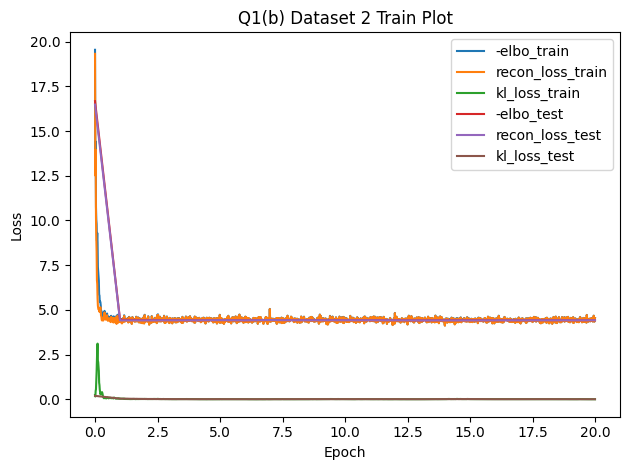

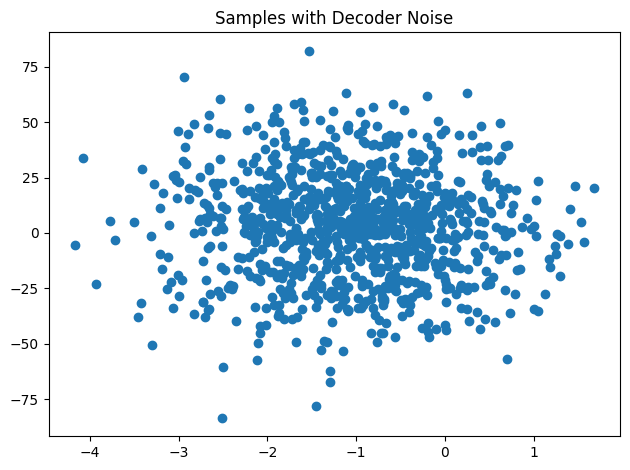

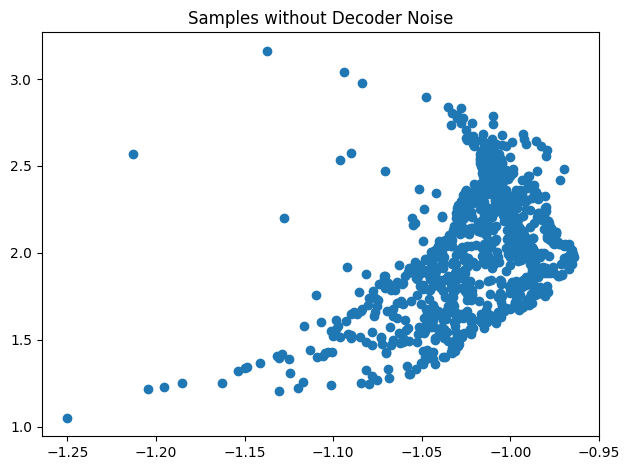

In [ ]:
q1_save_results('b', 2, q1)

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

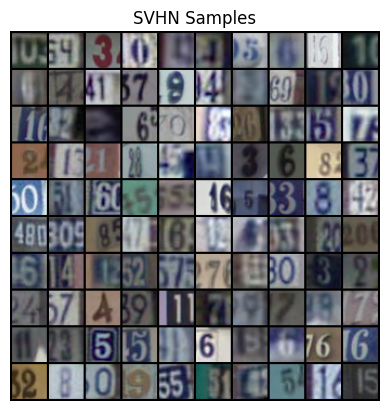

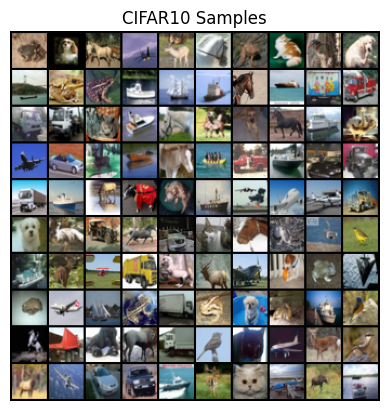

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class DecoderConv(nn.Module):
  def __init__(self, input_dim, output_shape):
    super().__init__()
    self.input_dim = input_dim
    self.output_shape = output_shape
    self.conv_input_shape = (128, output_shape[1]//8, output_shape[2]//8)
    self.fullyconnectedLayer = nn.Linear(input_dim,np.prod(self.conv_input_shape))
    self.decoderConvo = nn.Sequential(
        nn.ReLU(),
        nn.ConvTranspose2d(128,128,4,2,1),
        nn.ReLU(),
        nn.ConvTranspose2d(128,64,4,2,1),
        nn.ReLU(),
        nn.ConvTranspose2d(64,32,4,2,1),
        nn.ReLU(),
        nn.ConvTranspose2d(32,output_shape[0],3,1,1),
    )
  def forward(self, x):
    batch_size = x.shape[0]
    x = self.fullyconnectedLayer(x).contiguous().view(batch_size, *self.conv_input_shape)
    return self.decoderConvo(x)


class EncoderConv(nn.Module):
  def __init__(self, input_shape, latent_dim):
    super().__init__()
    self.input_shape = input_shape
    self.latent_dim = latent_dim
    self.encoderConvo = nn.Sequential(
        nn.Conv2d(input_shape[0],32,3,1,1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,2,1),
        nn.ReLU(),
        nn.Conv2d(64,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,256,3,2,1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(input_shape[1]//8 * input_shape[2]//8 *256, 2*latent_dim),
    )
  def forward(self, x):
    mu, log_std = self.encoderConvo(x).chunk(2, dim = 1)
    return mu, log_std
class ConvVAE(nn.Module):
  def __init__(self, latent_dim, input_shape):
    super().__init__()
    self.latent_dim = latent_dim
    self.input_shape= input_shape
    self.encoder = EncoderConv(input_shape, latent_dim)
    self.decoder = DecoderConv(latent_dim, input_shape)
  def loss(self, x):
    x = 2*x -1
    mu, log_std = self.encoder(x)
    z = torch.randn_like(mu)*torch.exp(log_std) + mu
    x_recon = self.decoder(z)

    recon_loss = F.mse_loss(x_recon, x, reduction = 'none').contiguous().view(x.shape[0], -1).sum(dim =1).mean()

    kl_loss = 0.5*(mu**2 + torch.exp(log_std)) - self.latent_dim/(2* self.latent_dim) - 0.5*log_std
    kl_loss = kl_loss.sum(dim =1).mean()
    return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)
  def sample(self, n):
    with torch.no_grad():
      z = torch.randn(n, self.latent_dim).cuda()
      samples = torch.clamp(self.decoder(z), -1,1)*0.5 +0.5
      return samples.cpu().permute(0,2,3,1).numpy()









In [ ]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = ConvVAE(16, (3, 32, 32)).cuda()
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epoch(model, train_loader, test_loader,
                                             dict(epochs=20, optimizer = optimizer, grad_clip = 1))
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255.

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

test: loss: 619.2997 recon_loss: 619.2969 kl_loss: 0.0028 


Epoch: 0loss: 313.9699recon_loss: 307.6563kl_loss: 6.3136: 100%|██████████| 79/79 [00:01<00:00, 51.76it/s]


test: loss: 243.7219 recon_loss: 230.2828 kl_loss: 13.4391 


Epoch: 1loss: 193.0936recon_loss: 182.5782kl_loss: 10.5155: 100%|██████████| 79/79 [00:01<00:00, 62.16it/s]


test: loss: 192.0219 recon_loss: 180.0765 kl_loss: 11.9454 


Epoch: 2loss: 157.8494recon_loss: 146.1255kl_loss: 11.7239: 100%|██████████| 79/79 [00:01<00:00, 59.15it/s]


test: loss: 154.7648 recon_loss: 140.9280 kl_loss: 13.8368 


Epoch: 3loss: 132.1937recon_loss: 119.5819kl_loss: 12.6118: 100%|██████████| 79/79 [00:01<00:00, 59.67it/s]


test: loss: 136.1556 recon_loss: 122.4459 kl_loss: 13.7098 


Epoch: 4loss: 119.6862recon_loss: 106.3083kl_loss: 13.3779: 100%|██████████| 79/79 [00:01<00:00, 62.26it/s]


test: loss: 139.7573 recon_loss: 125.8552 kl_loss: 13.9021 


Epoch: 5loss: 112.8735recon_loss: 99.2245kl_loss: 13.6490: 100%|██████████| 79/79 [00:01<00:00, 62.36it/s]


test: loss: 116.6893 recon_loss: 101.4766 kl_loss: 15.2127 


Epoch: 6loss: 100.8036recon_loss: 86.1404kl_loss: 14.6631: 100%|██████████| 79/79 [00:01<00:00, 62.34it/s]


test: loss: 106.0123 recon_loss: 89.9080 kl_loss: 16.1043 


Epoch: 7loss: 94.5673recon_loss: 79.6876kl_loss: 14.8796: 100%|██████████| 79/79 [00:01<00:00, 62.20it/s]


test: loss: 101.2829 recon_loss: 84.9549 kl_loss: 16.3280 


Epoch: 8loss: 92.6407recon_loss: 77.7165kl_loss: 14.9242: 100%|██████████| 79/79 [00:01<00:00, 62.14it/s]


test: loss: 98.4105 recon_loss: 82.2493 kl_loss: 16.1611 


Epoch: 9loss: 88.8563recon_loss: 73.8717kl_loss: 14.9846: 100%|██████████| 79/79 [00:01<00:00, 62.01it/s]


test: loss: 95.6278 recon_loss: 80.4934 kl_loss: 15.1344 


Epoch: 10loss: 86.8893recon_loss: 71.9390kl_loss: 14.9503: 100%|██████████| 79/79 [00:01<00:00, 58.49it/s]


test: loss: 93.4063 recon_loss: 77.2852 kl_loss: 16.1211 


Epoch: 11loss: 86.6046recon_loss: 71.6666kl_loss: 14.9380: 100%|██████████| 79/79 [00:01<00:00, 59.15it/s]


test: loss: 95.8930 recon_loss: 80.2153 kl_loss: 15.6777 


Epoch: 12loss: 86.3959recon_loss: 71.5260kl_loss: 14.8698: 100%|██████████| 79/79 [00:01<00:00, 61.43it/s]


test: loss: 93.9138 recon_loss: 78.7118 kl_loss: 15.2020 


Epoch: 13loss: 84.1574recon_loss: 69.2137kl_loss: 14.9436: 100%|██████████| 79/79 [00:01<00:00, 61.40it/s]


test: loss: 94.8780 recon_loss: 79.8643 kl_loss: 15.0137 


Epoch: 14loss: 84.1577recon_loss: 69.2789kl_loss: 14.8788: 100%|██████████| 79/79 [00:01<00:00, 61.04it/s]


test: loss: 93.6933 recon_loss: 77.0597 kl_loss: 16.6336 


Epoch: 15loss: 82.3019recon_loss: 67.3269kl_loss: 14.9749: 100%|██████████| 79/79 [00:01<00:00, 61.95it/s]


test: loss: 91.3048 recon_loss: 75.7134 kl_loss: 15.5914 


Epoch: 16loss: 82.3127recon_loss: 67.3690kl_loss: 14.9437: 100%|██████████| 79/79 [00:01<00:00, 61.48it/s]


test: loss: 93.9883 recon_loss: 78.1414 kl_loss: 15.8470 


Epoch: 17loss: 81.0998recon_loss: 66.1215kl_loss: 14.9783: 100%|██████████| 79/79 [00:01<00:00, 61.35it/s]


test: loss: 90.2347 recon_loss: 74.2959 kl_loss: 15.9388 


Epoch: 18loss: 80.6559recon_loss: 65.6955kl_loss: 14.9604: 100%|██████████| 79/79 [00:01<00:00, 59.57it/s]


test: loss: 89.2871 recon_loss: 73.4929 kl_loss: 15.7942 


Epoch: 19loss: 79.6023recon_loss: 64.5881kl_loss: 15.0142: 100%|██████████| 79/79 [00:01<00:00, 58.52it/s]


test: loss: 90.4506 recon_loss: 74.9004 kl_loss: 15.5502 
Final -ELBO: 90.4506, Recon Loss: 74.9004, KL Loss: 15.5502


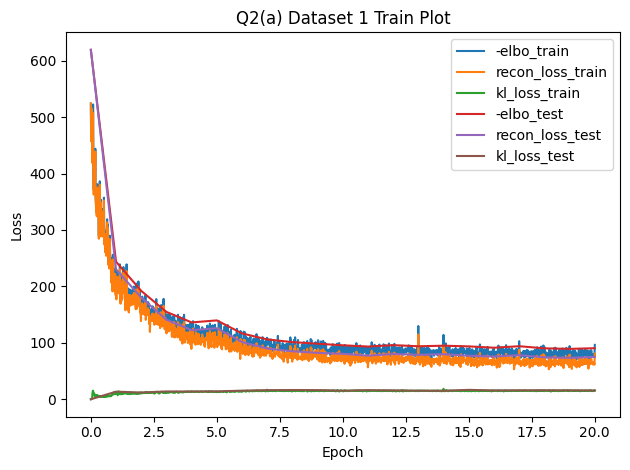

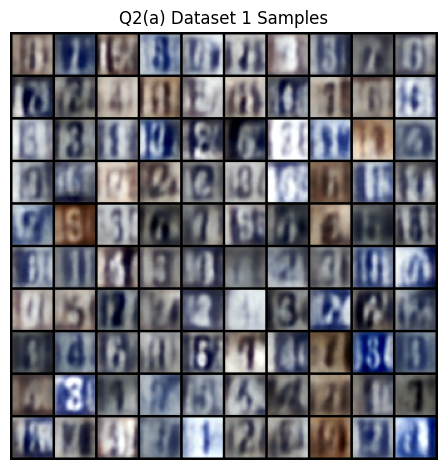

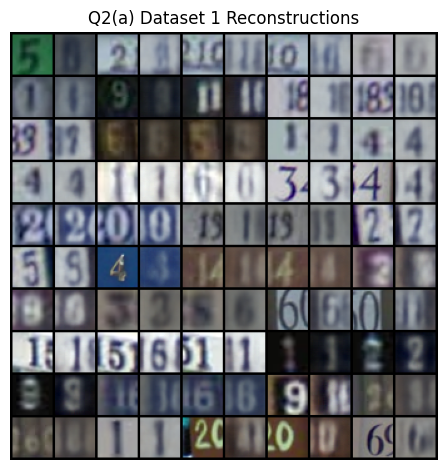

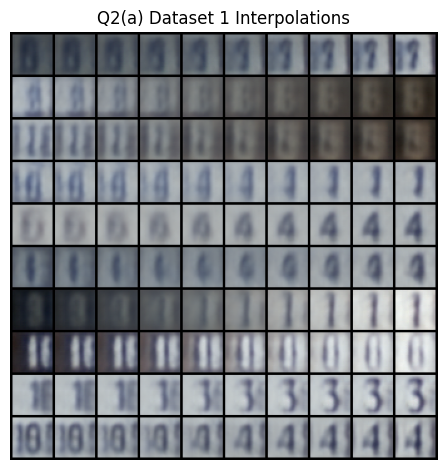

In [ ]:
q2_save_results('a', 1, q2_a)

test: loss: 823.4537 recon_loss: 823.4511 kl_loss: 0.0026 


Epoch: 0loss: 360.9409recon_loss: 345.3030kl_loss: 15.6379: 100%|██████████| 391/391 [00:06<00:00, 60.95it/s]


test: loss: 262.6721 recon_loss: 244.6155 kl_loss: 18.0567 


Epoch: 1loss: 243.8238recon_loss: 225.8157kl_loss: 18.0081: 100%|██████████| 391/391 [00:07<00:00, 54.34it/s]


test: loss: 235.0454 recon_loss: 217.8358 kl_loss: 17.2097 


Epoch: 2loss: 232.4354recon_loss: 214.4809kl_loss: 17.9545: 100%|██████████| 391/391 [00:06<00:00, 58.96it/s]


test: loss: 231.0038 recon_loss: 213.2282 kl_loss: 17.7757 


Epoch: 3loss: 228.8999recon_loss: 210.9642kl_loss: 17.9357: 100%|██████████| 391/391 [00:06<00:00, 60.06it/s]


test: loss: 228.9665 recon_loss: 211.1776 kl_loss: 17.7890 


Epoch: 4loss: 226.7291recon_loss: 208.8035kl_loss: 17.9256: 100%|██████████| 391/391 [00:06<00:00, 58.59it/s]


test: loss: 227.3388 recon_loss: 210.1457 kl_loss: 17.1931 


Epoch: 5loss: 224.3156recon_loss: 206.3507kl_loss: 17.9649: 100%|██████████| 391/391 [00:06<00:00, 59.71it/s]


test: loss: 225.6537 recon_loss: 207.2298 kl_loss: 18.4239 


Epoch: 6loss: 222.8434recon_loss: 204.8587kl_loss: 17.9847: 100%|██████████| 391/391 [00:06<00:00, 58.40it/s]


test: loss: 224.6826 recon_loss: 206.5038 kl_loss: 18.1788 


Epoch: 7loss: 221.4180recon_loss: 203.4145kl_loss: 18.0035: 100%|██████████| 391/391 [00:06<00:00, 58.81it/s]


test: loss: 223.5794 recon_loss: 205.4452 kl_loss: 18.1342 


Epoch: 8loss: 220.4389recon_loss: 202.4011kl_loss: 18.0377: 100%|██████████| 391/391 [00:06<00:00, 58.90it/s]


test: loss: 223.1724 recon_loss: 205.1232 kl_loss: 18.0492 


Epoch: 9loss: 218.6090recon_loss: 200.5683kl_loss: 18.0406: 100%|██████████| 391/391 [00:06<00:00, 58.12it/s]


test: loss: 222.8748 recon_loss: 204.9121 kl_loss: 17.9627 


Epoch: 10loss: 217.9991recon_loss: 199.9011kl_loss: 18.0980: 100%|██████████| 391/391 [00:06<00:00, 59.56it/s]


test: loss: 222.9587 recon_loss: 205.1320 kl_loss: 17.8267 


Epoch: 11loss: 217.3174recon_loss: 199.2012kl_loss: 18.1162: 100%|██████████| 391/391 [00:06<00:00, 58.00it/s]


test: loss: 223.0965 recon_loss: 205.4283 kl_loss: 17.6682 


Epoch: 12loss: 216.4684recon_loss: 198.3220kl_loss: 18.1464: 100%|██████████| 391/391 [00:06<00:00, 59.02it/s]


test: loss: 224.1598 recon_loss: 205.2662 kl_loss: 18.8937 


Epoch: 13loss: 216.0327recon_loss: 197.8705kl_loss: 18.1622: 100%|██████████| 391/391 [00:06<00:00, 57.66it/s]


test: loss: 222.0472 recon_loss: 203.9640 kl_loss: 18.0832 


Epoch: 14loss: 215.2053recon_loss: 197.0186kl_loss: 18.1867: 100%|██████████| 391/391 [00:06<00:00, 58.13it/s]


test: loss: 222.3949 recon_loss: 204.0944 kl_loss: 18.3005 


Epoch: 15loss: 214.3111recon_loss: 196.0918kl_loss: 18.2193: 100%|██████████| 391/391 [00:06<00:00, 58.61it/s]


test: loss: 222.0461 recon_loss: 203.8310 kl_loss: 18.2151 


Epoch: 16loss: 213.6147recon_loss: 195.3924kl_loss: 18.2223: 100%|██████████| 391/391 [00:06<00:00, 57.60it/s]


test: loss: 222.3674 recon_loss: 204.3540 kl_loss: 18.0133 


Epoch: 17loss: 213.0762recon_loss: 194.8088kl_loss: 18.2674: 100%|██████████| 391/391 [00:06<00:00, 58.44it/s]


test: loss: 222.6559 recon_loss: 204.2067 kl_loss: 18.4492 


Epoch: 18loss: 212.5564recon_loss: 194.2815kl_loss: 18.2749: 100%|██████████| 391/391 [00:06<00:00, 57.51it/s]


test: loss: 222.5661 recon_loss: 204.3863 kl_loss: 18.1799 


Epoch: 19loss: 211.9097recon_loss: 193.5942kl_loss: 18.3156: 100%|██████████| 391/391 [00:06<00:00, 57.79it/s]


test: loss: 222.3568 recon_loss: 204.0159 kl_loss: 18.3409 
Final -ELBO: 222.3568, Recon Loss: 204.0159, KL Loss: 18.3409


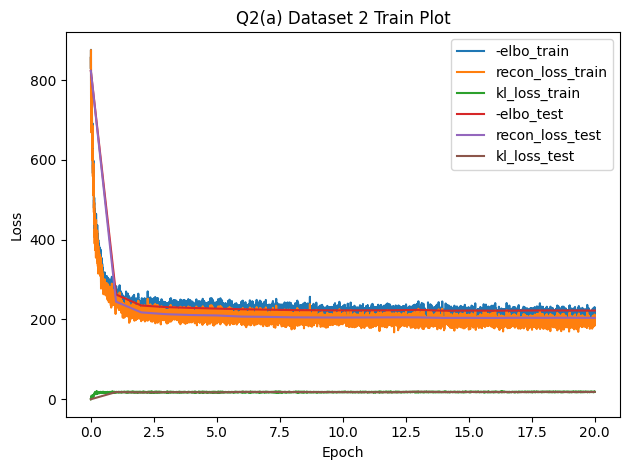

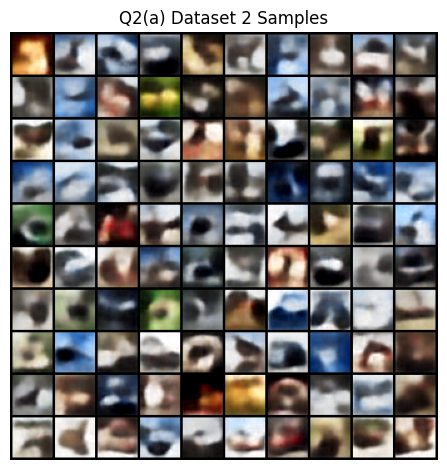

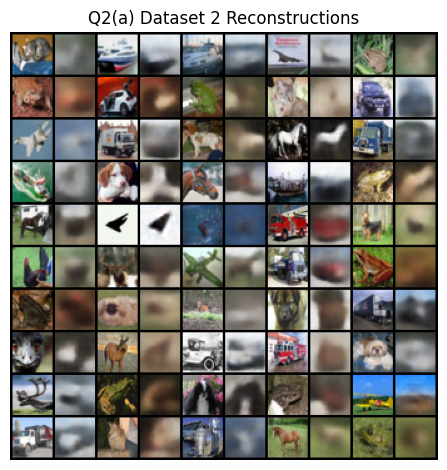

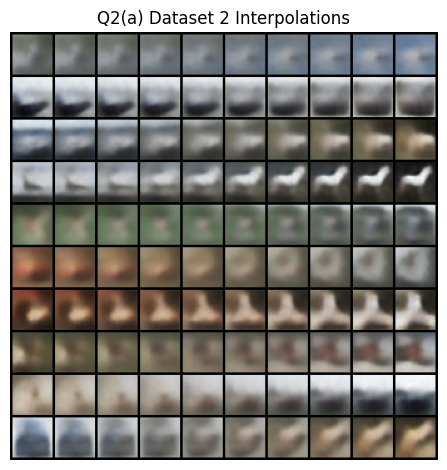

In [ ]:
q2_save_results('a', 2, q2_a)

## Part (b) VAE with AF Prior [20pts]
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\theta(z)$ and scale parameters $\sigma_\theta(z)$ and do the following transformation on $z$:
$$\epsilon = z * \sigma_\theta(z) + \mu_\theta(z)$$
and optimize the objective
$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class MaskedLinear(nn.Linear):
  def __init__(self, input_dim, output_dim, bias = True):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.register_buffer('mask', torch.ones(output_dim, input_dim))
  def set_mask(self, mask):
    self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
  def forward(self, x):
    return F.linear(x, self.mask *self.weight, bias)

class MADE(nn.Module):
  def __init__(self, input_shape, out_dim, hidden_size, ordering = None):
    super().__init__()
    self.input_shape = input_shape
    self.input_number = np.prod(input_shape)
    self.output_dim = self.input_number * out_dim
    self.ordering = np.arrange(self.input_number) if ordering is None else ordering
    self.hidden_size = hidden_size
    self.create_mask()


    self.layers = []
    layer_size = [self.input_number] + self.hidden_size + [self.output_dim]
    for input, output in zip(layer_size[:-1], layer_size[1:]):
      self.layers.extend([
          nn.MaskedLinear(input, output),
          nn.ReLU(),
      ])
    self.layers.pop()

    self.net = nn.Sequential(*self.layers)
  def create_mask(self):
    L = len(self.hidden_size)

    mask_layer = {}
    mask_layer[-1] = self.ordering
    for i in range(L):
      mask_layer[i] = np.random.randint(min(mask_layer[i-1]), self.input_number -1, size = hidden_size[i])
    mask_connection = [mask_layer[i][:, None] <= mask_layer[i+1][None, :] for i in range(L)]
    mask_connection.append(mask_layer[L-1][:, None] <= self.ordering[None, :])

    mask_connection[-1] = np.repeat(mask_connection[-1], d, axis = 1)

    linear_layers = [x for x in self.net.module() if  isinstance(x, nn.MaskedLinear)]

    for linear, mask in zip(linear_layers, mask_connection):
      linear.set_mask(mask)
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.contiguous().view(batch_size, -1)
    out = self.net(x).contiguous().view(batch_size, self.d, self.input_number)
class DecoderConv(nn.Module):
  def __init__(self, input_dim, output_shape):
    super().__init__()
    self.input_dim = input_dim
    self.output_shape = output_shape
    self.conv_input_shape = (128, output_shape[1]//8, output_shape[2]//8)
    self.fullyconnectedLayer = nn.Linear(input_dim,np.prod(self.conv_input_shape))
    self.decoderConvo = nn.Sequential(
        nn.ReLU(),
        nn.ConvTranspose2d(128,128,4,2,1),
        nn.ReLU(),
        nn.ConvTranspose2d(128,64,4,2,1),
        nn.ReLU(),
        nn.ConvTranspose2d(64,32,4,2,1),
        nn.ReLU(),
        nn.ConvTranspose2d(32,output_shape[0],3,1,1),
    )
  def forward(self, x):
    batch_size = x.shape[0]
    x = self.fullyconnectedLayer(x).contiguous().view(batch_size, *self.conv_input_shape)
    return self.decoderConvo(x)


class EncoderConv(nn.Module):
  def __init__(self, input_shape, latent_dim):
    super().__init__()
    self.input_shape = input_shape
    self.latent_dim = latent_dim
    self.encoderConvo = nn.Sequential(
        nn.Conv2d(input_shape[0],32,3,1,1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,2,1),
        nn.ReLU(),
        nn.Conv2d(64,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,256,3,2,1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(input_shape[1]//8 * input_shape[2]//8 *256, 2*latent_dim),
    )
  def forward(self, x):
    mu, log_std = self.encoderConvo(x).chunk(2, dim = 1)
    return mu, log_std


class AFVAE(nn.Module):
  def __init__(self, input_shape, latent_dim):
    super().__init__()
    self.input_shape = input_shape
    self.latent_dim = latent_dim
    self.made = MADE((latent_dim,), 2, [512, 512])
    self.encoder = EncoderConv(input_shape, latent_dim)
    self.decoder = DecoderConv(latent_dim, input_shape)

  def loss(self, x):
    x = 2*x -1
    mu, log_var = self.encoder(x)
    z = torch.randn_like(mu)*torch.sqrt(torch.exp(log_var)) + mu
    x_recon = self.decoder(z)

    recon_loss = F.mse_loss(x_recon, x, reduction = 'none').contiguous().view(x.shape[0], -1).sum(1).mean()

    enc_log_prob = -0.5 * np.log(2 * np.pi) - torch.log(torch.sqrt(log_var.exp())) - 0.5 * (z - mu_z) ** 2 * torch.exp(-1 * log_var)

    out = self.made(z)
    mu, log_std = out.chunk(2, dim=-1)
    log_std = torch.tanh(log_std)
    mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
    eps = z * torch.exp(log_std) + mu
    prior_log_prob = -0.5 * np.log(2 * np.pi) + log_std - 0.5 * eps ** 2

    kl_loss = (enc_log_prob - prior_log_prob).sum(1).mean()
    return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)













# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   For dataset 1, use a single Type A masked convolutions followed by 10 residual blocks (same as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   For dataset 2, use the same architecture as above but with 15 residual blocks
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
# building residual block
#residual_block(dim)
    #batch_norm2d(dim)
    #relu()
    #conv2d(dim, dim, 3, 1, 1)
    #batch_norm2d(dim)
    #relu()
    #conv2d(dim, dim, 1, 1, 0)

class ResidualBlock(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim
    self.net = nn.Sequential(
        nn.BatchNorm2d(dim),
        nn.ReLU(),
        nn.Conv2d(dim, dim, 3,1,1),
        nn.BatchNorm2d(dim),
        nn.ReLU(),
        nn.Conv2d(dim, dim, 1)
    )
  def forward(self, x):
    return x + self.net(x)

# building Layernorm using norm on features map layer
class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    out = super().forward(x)
    return out.permute(0, 3, 1, 2).contiguous()

#building quantized layer
class Quantizer(nn.Module):
  def __init__(self,codebook_size, codebook_dim):
    super().__init__()
    self.codebook_size = codebook_size
    self.codebook_dim = codebook_dim

    #init codebook = embedding weight
    self.embedding = nn.Embedding(codebook_size, codebook_dim)
    self.embedding.weight.data.uniform_(-1./codebook_size, 1./codebook_size)
    self.weight = self.embedding.weight


  def forward(self, x):
    b, c, h, w = x.shape
    flatten_input = x.permute(0, 2, 3, 1).contiguous().view(-1, self.codebook_dim)
    distance_matrix = (flatten_input ** 2).sum(dim = 1, keepdim = True) - 2* torch.mm(flatten_input, self.weight.t()) + (self.weight.t() **2).sum(dim = 0, keepdim = True)

    indices = torch.max(-distance_matrix, dim = 1)[1]

    indices = indices.contiguous().view(b, h, w)

    quantized_matrix = self.embedding(indices).permute(0, 3, 1, 2).contiguous()
    return quantized_matrix, (quantized_matrix -x).detach() + x, indices

# building Encoder class
#Encoder
 #   conv2d(3, 256, 4, 2, 1) 16 x 16
  #  batch_norm2d(256)
   # relu()
    #conv2d(256, 256, 4, 2, 1) 8 x 8
    #residual_block(256)
    #residual_block(256)
class Encoder(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.input_shape = input_shape

    self.net = nn.Sequential(
        nn.Conv2d(input_shape[0], 256, 4, 2, 1),# 16*16
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, 4, 2, 1),# 8*8
        ResidualBlock(256),
        ResidualBlock(256),
    )
  def forward(self, x):
    return self.net(x).contiguous()#batch * features_map * h * w (b*ft_m*8*8)


# building Decoder class
#Decoder
 #   residual_block(256)
  #  residual_block(256)
   # batch_norm2d(256)
    #relu()
    #transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    #batch_norm2d(256)
    #relu()
    #transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
class Decoder(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.input_shape = input_shape
    self.net = nn.Sequential(
        ResidualBlock(256),
        ResidualBlock(256),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, self.input_shape[0], 4, 2, 1),
        nn.Tanh(),
    )
  def forward(self, x):
    return self.net(x).contiguous()


# building VQ-VAE
class VQ_VAE(nn.Module):
  def __init__(self, codebook_size, codebook_dim, input_shape):
    super().__init__()
    self.codebook_size = codebook_size
    self.codebook_dim = codebook_dim
    self.input_shape = input_shape

    self.encoder = Encoder(input_shape)
    self.decoder = Decoder(input_shape)
    self.quantizer = Quantizer(self.codebook_size, self.codebook_dim)
  def forward(self, x):
    encode_z = self.encoder(x)
    quantized_e, quantized_e_strth, _ = self.quantizer(encode_z)
    recontruct_x = self.decoder(quantized_e_strth)
    loss_term_2 = torch.mean((encode_z - quantized_e.detach())**2)
    loss_term_3 = torch.mean((encode_z.detach() - quantized_e)**2)
    return recontruct_x, loss_term_2 + 0.25 *loss_term_3

  def loss(self, x):
    x = 2*x -1
    recontruct_x, loss_term_vae = self(x)
    recon_loss = F.mse_loss(recontruct_x, x, reduction = 'none').contiguous().view(x.shape[0], -1).sum(dim = 1).mean()
    loss = recon_loss + loss_term_vae
    return OrderedDict(loss = loss, recon_loss = recon_loss, reg_loss = loss_term_vae)
  def encode_code(self, x):
    with torch.no_grad():
      x = 2*x -1
      encode_z = self.encoder(x)
      indices = self.quantizer(encode_z)[2]
      return indices
  def decode_code(self, latents):
    with torch.no_grad():
      latents = self.quantizer.embedding(latents).permute(0, 3, 1, 2).contiguous()
      return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5



# building auto-regressive network for p(z)


# building mask conv 2D
class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros_like(self.weight))

    self.create_mask(self.mask_type)
  def forward(self, input):
    return F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
  def create_mask(self, mask_type):
    k = self.kernel_size[0]

    self.mask[:,:,0:k//2] = 1
    self.mask[:, :, k//2, 0:k//2] = 1
    if mask_type =='B':
      self.mask[:,:, k//2, k//2] = 1


# building pixelcnn residual class
class PixelCNNResidual(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim
    self.block = nn.Sequential(
      LayerNorm(dim),
      nn.ReLU(),
      MaskConv2d('B', dim, dim//2, 1 ),
      LayerNorm(dim//2),
      nn.ReLU(),
      MaskConv2d('B', dim//2, dim//2, 3,padding = 1),
      LayerNorm(dim//2),
      nn.ReLU(),
      MaskConv2d('B', dim//2, dim, 1)
     )
  def forward(self, x):
    return self.block(x) + x
# building pixelcnn class
class PixelCNN(nn.Module):
  def __init__(self, input_shape, code_size, dim = 256, n_layers = 7):
    super().__init__()
    self.input_shape = input_shape
    self.dim = dim
    self.code_size = code_size
    self.n_layers = n_layers

    self.embedding = nn.Embedding(code_size, dim)
    self.net = nn.ModuleList([
        MaskConv2d('A', dim, dim, 7, padding = 3),
        LayerNorm(dim),
        nn.ReLU()
    ])
    for _ in range(n_layers):
      self.net.append(PixelCNNResidual(dim))
    self.net.extend([
        LayerNorm(dim),
        nn.ReLU(),
        MaskConv2d('B', dim, 512, 1),
        nn.ReLU(),
        MaskConv2d('B', 512, code_size, 1)
    ])

  def forward(self, x):
    id_vector = self.embedding(x).permute(0, 3, 1, 2).contiguous()
    for layer in self.net:
      id_vector = layer(id_vector)
    return id_vector
  def loss(self, x):
    return OrderedDict(loss = F.cross_entropy(self(x), x))

  def sample(self, n):
    samples = torch.zeros(n, *self.input_shape).long().cuda()
    with torch.no_grad():
      for h in range(self.input_shape[0]):
        for w in range(self.input_shape[1]):
          logits = self(samples)[:,:,h, w]
          logits = F.softmax(logits, dim = 1)
          samples[:,h,w] = torch.multinomial(logits, 1).squeeze(-1)
    return samples












In [ ]:
def q3(train_data, test_data, dset_id):

  """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples (an equal number from each class) with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """



  train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype(np.float32)
  test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype(np.float32)

  codebook_size = 128
  codebook_dim = 256
  input_shape = train_data.shape[1:]
  vqvae = VQ_VAE(codebook_size, codebook_dim, input_shape)
  optimizer = optim.Adam(vqvae.parameters(), lr = 1e-3)
  train_loader = data.DataLoader(train_data, batch_size = 128, shuffle = True)
  test_loader = data.DataLoader(test_data, batch_size = 128)

  train_losses, test_losses = train_epoch(vqvae, train_loader, test_loader,
                                            dict(epochs = 20, optimizer = optimizer, grad_clip = 1))
  vqvae_train_losses, vqvae_test_losses = train_losses['loss'], test_losses['loss']

  def create_q_z_output(data_loader):
      q_z_output = []
      with torch.no_grad():
        for x in data_loader:
          x = x.cuda()
          out = vqvae.encode_code(x)
          q_z_output.append(out)
      return torch.cat(q_z_output, dim = 0)
  prior = PixelCNN(code_size = codebook_size, input_shape =(8,8), n_layers = 10).cuda()
  prior_optimizer = optim.Adam(prior.parameters(), lr = 1e-3)
  prior_train_data, prior_test_data = create_q_z_output(train_loader), create_q_z_output(test_loader)
  prior_train_loader = data.DataLoader(prior_train_data, batch_size = 128, shuffle = True)
  prior_test_loader = data.DataLoader(prior_test_data, batch_size = 128)

  prior_train_losses, prior_test_losses = train_epoch(prior, prior_train_loader, prior_test_loader,
                                                        dict(epochs = 20, optimizer = prior_optimizer, grad_clip = 1))
  prior_train_losses, prior_test_losses = prior_train_losses['loss'], prior_test_losses['loss']

  samples = prior.sample(100).long()
  samples = vqvae.decode_code(samples) *255
  x = next(iter(test_loader))[:50].cuda()
  with torch.no_grad():
        z = vqvae.encode_code(x)
        x_recon = vqvae.decode_code(z)
  x = x.cpu().permute(0, 2, 3, 1).numpy()
  reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

  return vqvae_train_losses, vqvae_test_losses, prior_train_losses, prior_test_losses, samples, reconstructions






test: loss: 846.5360 recon_loss: 846.5015 reg_loss: 0.0345 


Epoch: 0loss: 107484.2780recon_loss: 686.0383reg_loss: 106798.2401: 100%|██████████| 391/391 [00:25<00:00, 15.06it/s]


test: loss: 286148.1393 recon_loss: 589.0264 reg_loss: 285559.1121 


Epoch: 1loss: 387153.4161recon_loss: 448.6852reg_loss: 386704.7316: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]


test: loss: 385023.5044 recon_loss: 421.9862 reg_loss: 384601.5177 


Epoch: 2loss: 408335.0350recon_loss: 412.4329reg_loss: 407922.6025: 100%|██████████| 391/391 [00:26<00:00, 14.51it/s]


test: loss: 364840.3833 recon_loss: 401.4348 reg_loss: 364438.9467 


Epoch: 3loss: 360114.0517recon_loss: 384.5274reg_loss: 359729.5252: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s]


test: loss: 355172.6126 recon_loss: 373.7403 reg_loss: 354798.8723 


Epoch: 4loss: 357655.4579recon_loss: 366.0758reg_loss: 357289.3822: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s]


test: loss: 363828.3334 recon_loss: 363.9354 reg_loss: 363464.3980 


Epoch: 5loss: 359002.1223recon_loss: 358.9336reg_loss: 358643.1890: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]


test: loss: 364693.2204 recon_loss: 354.6754 reg_loss: 364338.5446 


Epoch: 6loss: 380591.1834recon_loss: 352.5061reg_loss: 380238.6777: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s]


test: loss: 403767.3550 recon_loss: 346.0525 reg_loss: 403421.3040 


Epoch: 7loss: 398905.7618recon_loss: 345.4676reg_loss: 398560.2940: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s]


test: loss: 414267.3269 recon_loss: 345.3353 reg_loss: 413921.9925 


Epoch: 8loss: 404073.4808recon_loss: 342.3536reg_loss: 403731.1271: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]


test: loss: 393323.2415 recon_loss: 342.9829 reg_loss: 392980.2591 


Epoch: 9loss: 390397.0766recon_loss: 340.7722reg_loss: 390056.3035: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s]


test: loss: 376758.7430 recon_loss: 332.5841 reg_loss: 376426.1590 


Epoch: 10loss: 370756.4882recon_loss: 334.3292reg_loss: 370422.1596: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s]


test: loss: 372902.8590 recon_loss: 330.2081 reg_loss: 372572.6517 


Epoch: 11loss: 349174.2396recon_loss: 329.0425reg_loss: 348845.1970: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s]


test: loss: 342346.1345 recon_loss: 329.7142 reg_loss: 342016.4195 


Epoch: 12loss: 327045.1269recon_loss: 322.9417reg_loss: 326722.1853: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]


test: loss: 315333.2035 recon_loss: 320.7240 reg_loss: 315012.4797 


Epoch: 13loss: 319930.0808recon_loss: 321.9571reg_loss: 319608.1236: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s]


test: loss: 318284.3664 recon_loss: 327.6091 reg_loss: 317956.7567 


Epoch: 14loss: 315164.9675recon_loss: 316.6891reg_loss: 314848.2781: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s]


test: loss: 324751.9761 recon_loss: 317.6290 reg_loss: 324434.3461 


Epoch: 15loss: 308078.7705recon_loss: 311.9486reg_loss: 307766.8227: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s]


test: loss: 304388.0850 recon_loss: 315.7609 reg_loss: 304072.3250 


Epoch: 16loss: 301496.4414recon_loss: 309.6574reg_loss: 301186.7848: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]


test: loss: 308115.4203 recon_loss: 313.0434 reg_loss: 307802.3773 


Epoch: 17loss: 295651.9011recon_loss: 306.9486reg_loss: 295344.9520: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]


test: loss: 298630.3983 recon_loss: 305.6745 reg_loss: 298324.7227 


Epoch: 18loss: 292504.8963recon_loss: 303.8679reg_loss: 292201.0290: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s]


test: loss: 295330.2800 recon_loss: 303.3984 reg_loss: 295026.8802 


Epoch: 19loss: 288801.3619recon_loss: 302.4844reg_loss: 288498.8769: 100%|██████████| 391/391 [00:26<00:00, 14.63it/s]


test: loss: 294802.9826 recon_loss: 305.2269 reg_loss: 294497.7555 
test: loss: 4.8727 


Epoch: 0loss: 2.0767: 100%|█████████▉| 390/391 [00:30<00:00, 12.78it/s]<ipython-input-8-37a4f0e4c0a1>:165: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
Epoch: 0loss: 2.0759: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


test: loss: 1.7543 


Epoch: 1loss: 1.6746: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


test: loss: 1.6499 


Epoch: 2loss: 1.5891: 100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


test: loss: 1.6074 


Epoch: 3loss: 1.5406: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


test: loss: 1.5873 


Epoch: 4loss: 1.5070: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


test: loss: 1.5676 


Epoch: 5loss: 1.4801: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


test: loss: 1.5647 


Epoch: 6loss: 1.4569: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


test: loss: 1.5641 


Epoch: 7loss: 1.4361: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


test: loss: 1.5616 


Epoch: 8loss: 1.4172: 100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


test: loss: 1.5537 


Epoch: 9loss: 1.3999: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


test: loss: 1.5645 


Epoch: 10loss: 1.3833: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


test: loss: 1.5636 


Epoch: 11loss: 1.3690: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]


test: loss: 1.5699 


Epoch: 12loss: 1.3527: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


test: loss: 1.5740 


Epoch: 13loss: 1.3390: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


test: loss: 1.5743 


Epoch: 14loss: 1.3248: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


test: loss: 1.5867 


Epoch: 15loss: 1.3118: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


test: loss: 1.5855 


Epoch: 16loss: 1.2996: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


test: loss: 1.5990 


Epoch: 17loss: 1.2860: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]


test: loss: 1.6035 


Epoch: 18loss: 1.2743: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


test: loss: 1.6126 


Epoch: 19loss: 1.2619: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


test: loss: 1.6178 
VQ-VAE Final Test Loss: 294802.9826
Transformer Prior Final Test Loss: 1.6178


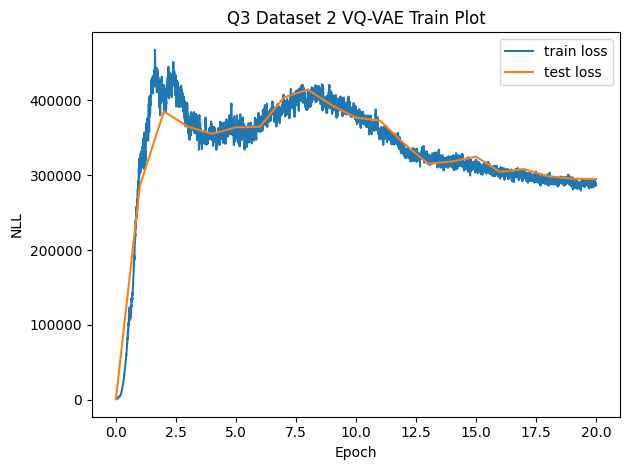

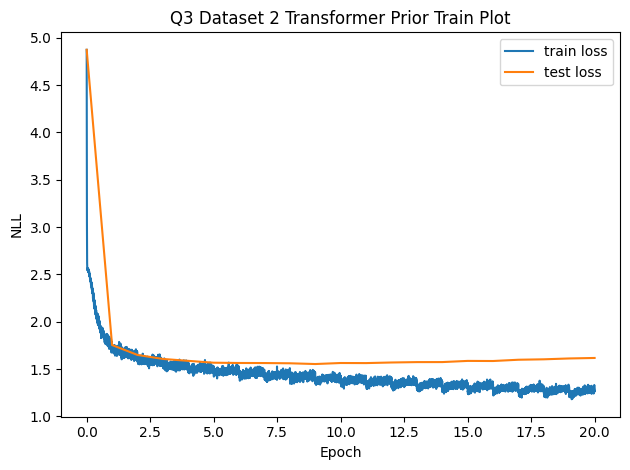

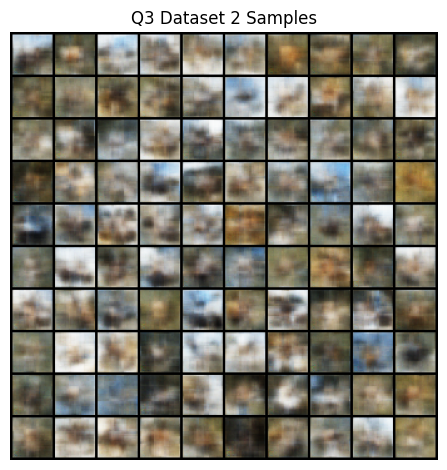

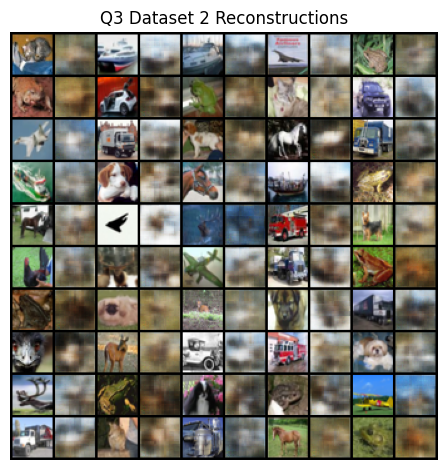

In [ ]:
q3_save_results(2, q3)